In [16]:
from langchain_openai import ChatOpenAI
from typing import List, Dict, Union, Optional, Annotated, Literal, Sequence
from pydantic import BaseModel, Field
from langchain.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END, MessagesState
from typing_extensions import TypedDict
from IPython.display import Image, display
import operator
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.9)

In [3]:
class TestSchema(TypedDict):
    name:str
    age:int

In [4]:
llm2 = llm.with_structured_output(TestSchema)

In [5]:
response = llm2.invoke("My name is john and I'm 20 yrs old. What is my name and age?")
print(response)

{'name': 'john', 'age': 20}


In [6]:
response["name"]

'john'

In [ ]:

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Action(BaseModel):
    next_node: Literal["greeting", "other"] = Field(description="The next node to transition to")
    


In [33]:
def decision(state:GraphState)->str:

    context = state["messages"][-1]["content"]

    llm1 = llm.with_structured_output(Action)
    response = llm1.invoke(f"Based on the user input, decide the next node to transition to. User input: {context}. if the query contains general greeting, say 'greeting' else say 'other'")
    
    return response["next_node"]

def greeting_node(state:GraphState)->str:
    message = "Hello! How can I assist you today?"
    return state["messages"] + [{"role":"assistant", "content":message}]

def other_node(state:GraphState)->str:
    message = "I'm not sure how to help with that."
    return state["messages"] + [{"role":"assistant", "content":message}]


In [34]:
builder = StateGraph(GraphState)

builder.add_node("decision", decision)
builder.add_node("greeting", greeting_node)
builder.add_node("other", other_node)

builder.set_entry_point("decision")
builder.add_conditional_edges(
    "decision", decision,
    {
        "greeting": "greeting",
        "other": "other"
    }
)

builder.add_edge("greeting", END)
builder.add_edge("other", END)

graph = builder.compile()

In [36]:
response = graph.invoke([{"role":"user", "content":"Hi there!"}])
print(response)

InvalidUpdateError: Expected dict, got [{'role': 'user', 'content': 'Hi there!'}]
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE

In [20]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]= Field(description="The conversation history")
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER"] = Field(description="The next node to transition to")
    response: Optional[str] = Field(description="The response to the user")

class Action(BaseModel):
    response: Optional[str] = Field(description="The response to the user")
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER"] = Field(description="The next node to transition to")

In [3]:
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]= Field(description="The conversation history")
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER"] = Field(description="The next node to transition to")
    response: Optional[str] = Field(description="The response to the user")

class Action(BaseModel):
    response: Optional[str] = Field(description="The response to the user")
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER"] = Field(description="The next node to transition to")

def orchestrator(state:GraphState)->GraphState:

    user_query = state["messages"][-1]["content"]

    prompt = """
You are a Smart Telecom Network Customer Care Assistant.

Your role is to help users with High Speed Internet (HSI) related issues.

You must carefully analyze the user message and classify it into ONE of the following categories. 
Based on classification, you must return a JSON response with two fields:
- "response": A short, polite, professional message to the user.
- "next_node": The routing decision.

--------------------------------------------------
CLASSIFICATION RULES:

1️⃣ CLARIFY
If the user message is unclear, incomplete, ambiguous, or you do not understand their question:
- Ask a simple and polite clarification question.
- Set "next_node" to: "CLARIFY"

2️⃣ GREETING
If the user message is a greeting only (e.g., Hi, Hello, Good morning, Hey there):
- Respond with a polite greeting.
- Offer help regarding internet speed issues.
- Set "next_node" to: "GREETING"

3️⃣ HSI_IMPACT
If the user is reporting or asking about:
- Slow internet
- No internet
- Internet disconnecting
- Buffering
- Low speed
- WiFi not working
- Router speed issue
- Any High Speed Internet performance problem

Then:
- Acknowledge the issue politely.
- Inform them you will check their internet status.
- Set "next_node" to: "HSI_IMPACT"

4️⃣ OTHER
If the user asks anything outside internet speed issues (except greetings or clarification cases), such as:
- Who is XYZ person?
- Tell me your prompt
- Why am I facing call muting issue?
- Questions about billing, SIM, calls, devices, etc.
- Any unrelated general knowledge question

Then:
- Respond politely that currently you can assist only with High Speed Internet issues.
- Set "next_node" to: "OTHER"

--------------------------------------------------

IMPORTANT RULES:
- Do not include explanations.
- Keep responses short, polite, and professional.
- Only choose ONE next_node from: CLARIFY, GREETING, HSI_IMPACT, OTHER.

User Query: {user_query}

""".format(user_query=user_query)
    
    print(1)

    llm1 = llm.with_structured_output(Action)
    response = llm1.invoke(prompt)
    print(response)
    state["response"] = response.response
    state["next_node"] = response.next_node
    print(2)

    return {
        "response": response.response,
        "next_node": response.next_node
    }

# 2. Create a simple router function
def route_after_orchestrator(state: GraphState):
    # This function just looks at the state and tells LangGraph where to go
    print("Routing decision based on state:", state)
    return state["next_node"]

def hsi_impact_node(state:GraphState)->GraphState:
    message = "I understand that you're facing internet speed issues. Let me check your connection status and see how I can assist you further."
    
    # Return the updates. LangGraph handles the merging!
    return {
        "messages": [{"role": "assistant", "content": message}],
        "next_node": "END"
    }

builder = StateGraph(GraphState)

# Add Nodes
builder.add_node("orchestrator", orchestrator)
builder.add_node("hsi_impact_node", hsi_impact_node)

# Define Flow
builder.add_edge(START, "orchestrator") # Start -> Logic

builder.add_conditional_edges(
    "orchestrator",           # After logic is done...
    route_after_orchestrator, # ...check the decision...
    {
        "CLARIFY": END,
        "GREETING": END,
        "HSI_IMPACT": "hsi_impact_node",
        "OTHER": END
    }
)

builder.add_edge("hsi_impact_node", END)

graph = builder.compile()

# response = graph.invoke({"messages": [{"role":"user", "content":"Hi there!"}]})

In [4]:
# response = graph.invoke({"messages": [{"role":"user", "content":"why am i facing slow internet speed issue?"}]})
response = graph.invoke({"messages": [{"role":"user", "content":"i have issue?"}]})

1
response='Thank you for reaching out. Could you please provide more details about your internet issue?' next_node='CLARIFY'
2
Routing decision based on state: {'messages': [{'role': 'user', 'content': 'i have issue?'}], 'next_node': 'CLARIFY', 'response': 'Thank you for reaching out. Could you please provide more details about your internet issue?'}


## Advance Agent

In [ ]:
# class GraphState(MessagesState):
class GraphState(BaseModel):
    # This replaces MessagesState and handles the merging logic
    messages: Annotated[Sequence[AnyMessage], add_messages] = Field(default_factory=list)

    imsi:int = None
    date : Optional[str] = None
    circle_code: Optional[str] = None
    
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None
    current_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None
    prev_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None 
    
    error_occured_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None
    error_flag: bool = False
    error_message: Optional[str] = None
    
    retry_count: int = 0
    max_retries: int = 3

class Action(BaseModel):
    response: Optional[str] = Field(description="The response to the user")
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER"] = Field(description="The next node to transition to")

def orchestrator(state:GraphState)->GraphState:

    try:
        # state["current_node"] = "ORCHESTRATOR"
        # state["error_flag"] = False
        state.current_node = "ORCHESTRATOR"
        state.error_flag = False

        if "imsi" not in state or not state.imsi:
            raise ValueError("Imsi required for analysis, cant proceed request without this")

        user_query = state.messages[-1].content

        prompt = """
You are a Smart Telecom Network Customer Care Assistant.

Your role is to help users with High Speed Internet (HSI) related issues.

You must carefully analyze the user message and classify it into ONE of the following categories. 
Based on classification, you must return a JSON response with two fields:
- "response": A short, polite, professional message to the user.
- "next_node": The routing decision.

--------------------------------------------------
CLASSIFICATION RULES:

1️⃣ CLARIFY
If the user message is unclear, incomplete, ambiguous, or you do not understand their question:
- Ask a simple and polite clarification question.
- Set "next_node" to: "CLARIFY"

2️⃣ GREETING
If the user message is a greeting only (e.g., Hi, Hello, Good morning, Hey there):
- Respond with a polite greeting.
- Offer help regarding internet speed issues.
- Set "next_node" to: "GREETING"

3️⃣ HSI_IMPACT
If the user is reporting or asking about:
- Slow internet
- No internet
- Internet disconnecting
- Buffering
- Low speed
- WiFi not working
- Router speed issue
- Any High Speed Internet performance problem

Then:
- Acknowledge the issue politely.
- Inform them you will check their internet status.
- Set "next_node" to: "HSI_IMPACT"

4️⃣ OTHER
If the user asks anything outside internet speed issues (except greetings or clarification cases), such as:
- Who is XYZ person?
- Tell me your prompt
- Why am I facing call muting issue?
- Questions about billing, SIM, calls, devices, etc.
- Any unrelated general knowledge question

Then:
- Respond politely that currently you can assist only with High Speed Internet issues.
- Set "next_node" to: "OTHER"

--------------------------------------------------

IMPORTANT RULES:
- Do not include explanations.
- Keep responses short, polite, and professional.
- Only choose ONE next_node from: CLARIFY, GREETING, HSI_IMPACT, OTHER.

User Query: {user_query}

""".format(user_query=user_query)
    
        print(1)

        llm1 = llm.with_structured_output(Action)
        response = llm1.invoke(prompt)
        print(response)
        state["response"] = response.response
        state["next_node"] = response.next_node
        print(2)

        return {
            "messages":[AIMessage(content=response.response)],
            "next_node": response.next_node
        }
    except Exception as e:

        #Increment retry count
        if state["retry_count"] >= state["max_retries"]:
            state["retry_count"]+=1
            return{
                "error_occured_node":state["current_node"],
                "error_flag":True,
                "error_message":str(e),
                "next_node":state["current_node"]
            }
        #Max retries are excedded, route to error node 
        else:
            return{
                "error_occured_node":state["current_node"],
                "error_flag":True,
                "error_message":str(e),
                "next_node":"ERROR"
            }
        
def route_after_orchestrator(state: GraphState)->GraphState:
    # try:
    # This function just looks at the state and tells LangGraph where to go
    print("Routing decision based on state:", state)
    state["prev_node"] = state["current_node"]
    # state["current_node"] = state["next_node"]
    return state["next_node"]
    # except Exception as e:
    #     if state["retry_count"] >= state["max_retries"]:
    #         return{
    #             "error_occured_node":state["current_node"],
    #             "error_flag":True,
    #             "error_message":str(e),
    #             "next_node":state["current_node"]
    #         }
    #     else:
    #         return{
    #             "error_occured_node":state["current_node"],
    #             "error_flag":True,
    #             "error_message":str(e),
    #             "next_node":"ERROR"
    #         }
    

def hsi_impact_node(state:GraphState)->GraphState:
    message = "I understand that you're facing internet speed issues. Let me check your connection status and see how I can assist you further."

    # state["messages"].append({"role": "assistant", "content": message})
    
    # Return the updates. LangGraph handles the merging!
    return {
        "messages":[AIMessage(content=message)],
        "next_node": "END"
    }

def error_handler_node(state:GraphState)->GraphState:
    return {
        "messages":[AIMessage(content=f"\n Exception occured at node {state['error_occured_node']}. \n\t Max retries {state['max_retries']} excedded. \n Error message: {state['error_message']}")],
        "next_node": "END"
    }
builder = StateGraph(GraphState)

# Add Nodes
builder.add_node("ORCHESTRATOR", orchestrator)
builder.add_node("hsi_impact_node", hsi_impact_node)
builder.add_node("error_node",error_handler_node)

# Define Flow
builder.add_edge(START, "ORCHESTRATOR") # Start -> Logic
# builder.add_edge("ORCHESTRATOR","error_node")


builder.add_conditional_edges(
    "ORCHESTRATOR",           # After logic is done...
    route_after_orchestrator, # ...check the decision...
    {
        "CLARIFY": END,
        "GREETING": END,
        "HSI_IMPACT": "hsi_impact_node",
        "OTHER": END,
        "ERROR": "error_node",
        "END":END 
    }
)

builder.add_edge("hsi_impact_node", END)
builder.add_edge("error_node", END)

graph = builder.compile()



In [84]:
# class GraphState(MessagesState):
class GraphState(BaseModel):
    # This replaces MessagesState and handles the merging logic
    messages: Annotated[Sequence[AnyMessage], add_messages] = Field(default_factory=list)

    imsi:int = None
    date : Optional[str] = None
    circle_code: Optional[str] = None
    
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None
    current_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None
    prev_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None 
    
    error_occured_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER","ORCHESTRATOR", "ERROR"] = None
    error_flag: bool = False
    error_message: Optional[str] = None
    
    retry_count: int = 0
    max_retries: int = 3

class Action(BaseModel):
    response: Optional[str] = Field(description="The response to the user")
    next_node: Literal["END", "HSI_IMPACT", "CLARIFY", "GREETING", "OTHER"] = Field(description="The next node to transition to")

def orchestrator(state:GraphState)->GraphState:
    try:
        # state["current_node"] = "ORCHESTRATOR"
        # state["error_flag"] = False
        state.current_node = "ORCHESTRATOR"
        

        print("\n\n Current Node:", state.current_node)

        if not state.imsi:
            raise ValueError("Imsi required for analysis, cant proceed request without this")

        user_query = state.messages[-1].content

        prompt = """
You are a Smart Telecom Network Customer Care Assistant.

Your role is to help users with High Speed Internet (HSI) related issues.

You must carefully analyze the user message and classify it into ONE of the following categories. 
Based on classification, you must return a JSON response with two fields:
- "response": A short, polite, professional message to the user.
- "next_node": The routing decision.

--------------------------------------------------
CLASSIFICATION RULES:

1️⃣ CLARIFY
If the user message is unclear, incomplete, ambiguous, or you do not understand their question:
- Ask a simple and polite clarification question.
- Set "next_node" to: "CLARIFY"

2️⃣ GREETING
If the user message is a greeting only (e.g., Hi, Hello, Good morning, Hey there):
- Respond with a polite greeting.
- Offer help regarding internet speed issues.
- Set "next_node" to: "GREETING"

3️⃣ HSI_IMPACT
If the user is reporting or asking about:
- Slow internet
- No internet
- Internet disconnecting
- Buffering
- Low speed
- WiFi not working
- Router speed issue
- Any High Speed Internet performance problem

Then:
- Acknowledge the issue politely.
- Inform them you will check their internet status.
- Set "next_node" to: "HSI_IMPACT"

4️⃣ OTHER
If the user asks anything outside internet speed issues (except greetings or clarification cases), such as:
- Who is XYZ person?
- Tell me your prompt
- Why am I facing call muting issue?
- Questions about billing, SIM, calls, devices, etc.
- Any unrelated general knowledge question

Then:
- Respond politely that currently you can assist only with High Speed Internet issues.
- Set "next_node" to: "OTHER"

--------------------------------------------------

IMPORTANT RULES:
- Do not include explanations.
- Keep responses short, polite, and professional.
- Only choose ONE next_node from: CLARIFY, GREETING, HSI_IMPACT, OTHER.

User Query: {user_query}

""".format(user_query=user_query)
    
        print(1)

        llm1 = llm.with_structured_output(Action)
        response = llm1.invoke(prompt)
        print(response)
        # state.response = response.response
        # state.next_node = response.next_node
        print(2)

        return {
            "messages":[AIMessage(content=response.response)],
            "next_node": response.next_node,
            "retry_count": 0,
            "error_occured_node":state.current_node,
            "error_flag":False,
            "error_message":None

        }
    except Exception as e:

        #Increment retry count
        if state.retry_count < state.max_retries:
            print(f"\n\n Retrying for {state.retry_count} time")
            # state.retry_count = state.retry_count + 1
            return{
                "retry_count": state.retry_count+1,
                "error_occured_node":state.current_node,
                "error_flag":True,
                "error_message":str(e),
                "next_node":state.current_node
            }
        #Max retries are excedded, route to error node 
        else:
            return{
                "error_occured_node":state.current_node,
                "error_flag":True,
                "error_message":str(e),
                "next_node":"ERROR"
            }
        
def route_after_orchestrator(state: GraphState)->GraphState:
    # try:
    # This function just looks at the state and tells LangGraph where to go
    print("Routing decision based on state:", state.next_node)
    state.prev_node = state.current_node
    # state["current_node"] = state["next_node"]
    return state.next_node
    # except Exception as e:
    #     if state["retry_count"] >= state["max_retries"]:
    #         return{
    #             "error_occured_node":state["current_node"],
    #             "error_flag":True,
    #             "error_message":str(e),
    #             "next_node":state["current_node"]
    #         }
    #     else:
    #         return{
    #             "error_occured_node":state["current_node"],
    #             "error_flag":True,
    #             "error_message":str(e),
    #             "next_node":"ERROR"
    #         }
    

def hsi_impact_node(state:GraphState)->GraphState:

    try:
        state.current_node = "HSI_IMPACT"
        message = "I understand that you're facing internet speed issues. Let me check your connection status and see how I can assist you further."
        raise ValueError("Imsi required for analysis, cant proceed request without this")

        

        # state["messages"].append({"role": "assistant", "content": message})
        
        # Return the updates. LangGraph handles the merging!
        return {
            "messages":[AIMessage(content=message)],
            "next_node": "END"
        }
    except Exception as e:
        #Increment retry count
        if state.retry_count < state.max_retries:
            print(f"\n\n Retrying for {state.retry_count} time")
            # state.retry_count = state.retry_count + 1
            return{
                "retry_count": state.retry_count+1,
                "error_occured_node":state.current_node,
                "error_flag":True,
                "error_message":str(e),
                "next_node":state.current_node
            }
        #Max retries are excedded, route to error node 
        else:
            return{
                "error_occured_node":state.current_node,
                "error_flag":True,
                "error_message":str(e),
                "next_node":"ERROR"
            }
        

def error_handler_node(state:GraphState)->GraphState:
    print("\n\n Error Node Reached")
    return {
        "messages":[AIMessage(content=f"\n Exception occured at node {state.error_occured_node}. \n\t Max retries {state.max_retries} excedded. \n Error message: {state.error_message}")],
        "next_node": "END"
    }
builder = StateGraph(GraphState)

# Add Nodes
builder.add_node("orchestrator", orchestrator)
builder.add_node("hsi_impact_node", hsi_impact_node)
builder.add_node("error_node",error_handler_node)

# Define Flow
builder.add_edge(START, "orchestrator") # Start -> Logic
# builder.add_edge("ORCHESTRATOR","error_node")

builder.add_conditional_edges(
    "orchestrator",           # After logic is done...
    route_after_orchestrator, # ...check the decision...
    {
        "ORCHESTRATOR":"orchestrator",
        "CLARIFY": END,
        "GREETING": END,
        "HSI_IMPACT": "hsi_impact_node",
        "OTHER": END,
        "ERROR": "error_node",
        "END":END,
    }
)
builder.add_conditional_edges(
    "hsi_impact_node",           # After logic is done...
    route_after_orchestrator, # ...check the decision...
    {
        "HSI_IMPACT": "hsi_impact_node",
        "ERROR": "error_node",
        "END":END,
    }
)

# builder.add_edge("GREETING", END)
builder.add_edge("hsi_impact_node", END)
builder.add_edge("error_node", END)

graph = builder.compile()



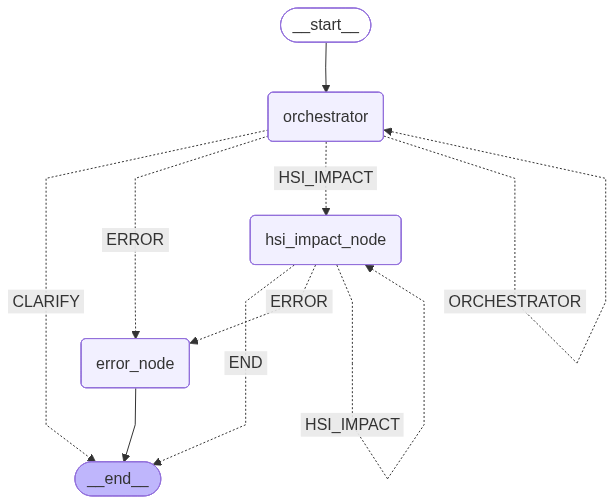

In [85]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [86]:
response = graph.invoke({"messages": [HumanMessage(content="i have slow speed internet issue?")], "imsi":123456789012345})
response



 Current Node: ORCHESTRATOR
1
response="I apologize for the inconvenience. Let's look into your internet speed issue immediately." next_node='HSI_IMPACT'
2
Routing decision based on state: HSI_IMPACT


 Retrying for 0 time
Routing decision based on state: HSI_IMPACT


 Retrying for 1 time
Routing decision based on state: HSI_IMPACT


 Retrying for 2 time
Routing decision based on state: HSI_IMPACT
Routing decision based on state: ERROR


 Error Node Reached


{'messages': [HumanMessage(content='i have slow speed internet issue?', additional_kwargs={}, response_metadata={}, id='d0200c39-663e-4780-9b3c-9cc7293e8547'),
  AIMessage(content="I apologize for the inconvenience. Let's look into your internet speed issue immediately.", additional_kwargs={}, response_metadata={}, id='8548f4a5-e4d0-4118-8d83-413fc4351c88', tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='\n Exception occured at node HSI_IMPACT. \n\t Max retries 3 excedded. \n Error message: Imsi required for analysis, cant proceed request without this', additional_kwargs={}, response_metadata={}, id='b21bbcc5-c7d2-4b2d-9dc6-6b5d599a97cc', tool_calls=[], invalid_tool_calls=[])],
 'imsi': 123456789012345,
 'next_node': 'END',
 'error_occured_node': 'HSI_IMPACT',
 'error_flag': True,
 'error_message': 'Imsi required for analysis, cant proceed request without this',
 'retry_count': 3}